In [72]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [219]:
class MotorImageryDataset:
    def __init__(self, dataset='A01T.npz'):
        if not dataset.endswith('.npz'):
            dataset += '.npz'
        
        self.data = np.load(dataset)
        
        self.Fs = 250 # 250Hz from original paper
        
        # keys of data ['s', 'etyp', 'epos', 'edur', 'artifacts']
        
        self.raw = self.data['s'].T
        self.events_type = self.data['etyp'].T
        self.events_position = self.data['epos'].T
        self.events_duration = self.data['edur'].T
        self.artifacts = self.data['artifacts'].T
        
        # Types of motor imagery
        self.mi_types = {769: 'left', 770: 'right', 771: 'foot', 772: 'tongue', 783: 'unknown'}

    def get_trials_from_channel(self, channel=7):
        
        # Channel default is C3
        
        startrial_code = 768
        starttrial_events = self.events_type == startrial_code
        idxs = [i for i, x in enumerate(starttrial_events[0]) if x]
        
        trials = []
        classes = []
        
        for index in idxs:
            try:
                type_e = self.events_type[0, index+1]
                class_e = self.mi_types[type_e]
                classes.append(class_e)
                
                start = self.events_position[0, index]
                stop = start + self.events_duration[0, index]
                trial = self.raw[channel, start:stop]
                trial = trial.reshape((1, -1))
                trials.append(trial)
                
            except:
                continue
    
        return trials, classes
    
    def get_trials_from_channels(self, channels=[7, 9, 11]):
        trials_c = []
        classes_c = []
        for c in channels:
            t, c = self.get_trials_from_channel(channel=c)

            tt = np.concatenate(t, axis=0)
            trials_c.append(tt)
            classes_c.append(c)

        return trials_c, classes_c

In [220]:
datasetA1 = MotorImageryDataset()

In [342]:
trials, classes = datasetA1.get_trials_from_channels()

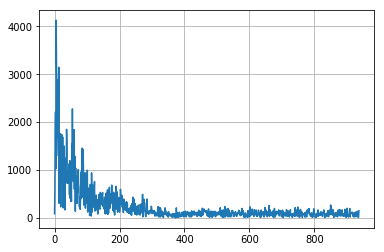

In [255]:
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(trials[0][3])))[int(len(trials[0][3])/2):])
plt.grid()

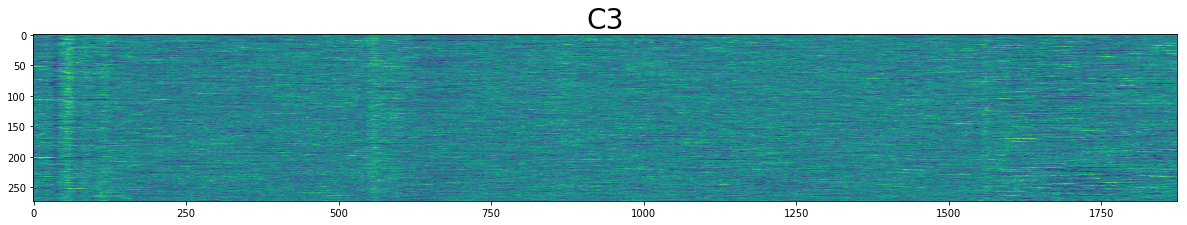

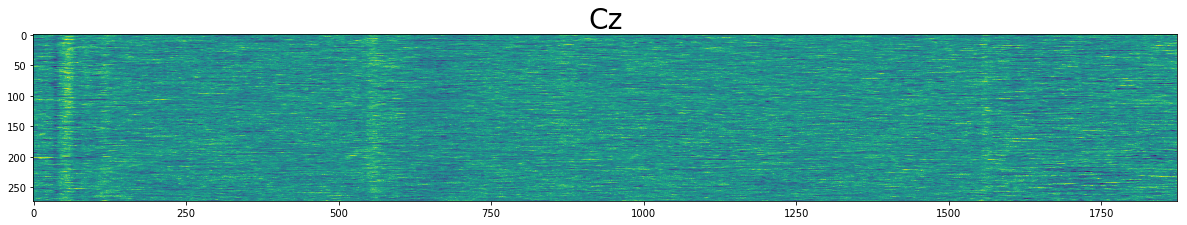

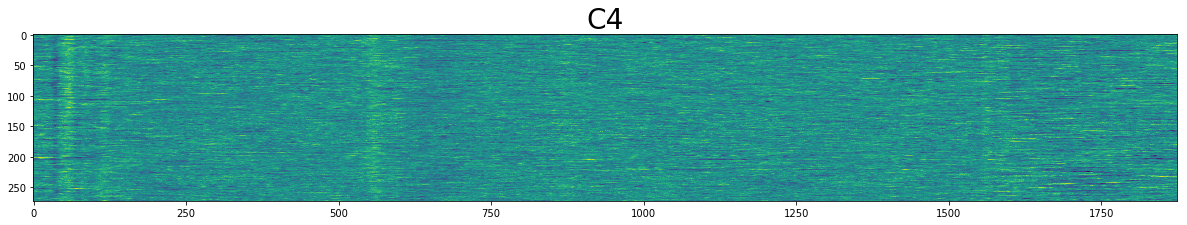

In [222]:
plt.figure(1)
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
plt.title('C3', size=28)
plt.imshow(trials[0])

plt.figure(2)
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
plt.title('Cz', size=28)
plt.imshow(trials[1])

plt.figure(3)
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
plt.title('C4', size=28)
plt.imshow(trials[2])

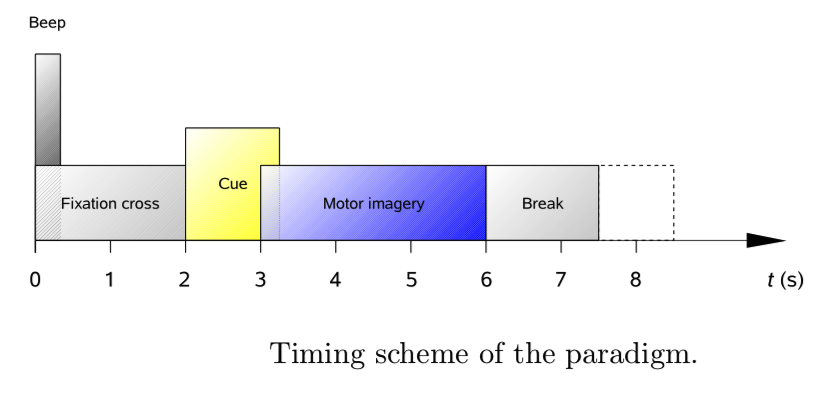

In [343]:
trials = np.concatenate([trials], axis=2)

In [344]:
trials.shape

(3, 273, 1875)

In [345]:
fixed_trials = trials.reshape((-1, 3, 1875))
minft = fixed_trials.min()
maxft = fixed_trials.max()
fixed_trials = ((fixed_trials - minft)/(maxft - minft))

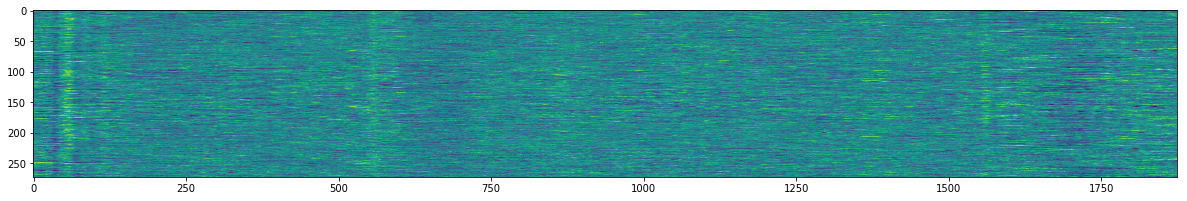

In [354]:
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
plt.imshow(fixed_trials[:, 0, :])

In [379]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, Adamax, SGD

In [400]:
class GAN():
    def __init__(self):
        self.img_rows = 3
        self.img_cols = 1875
#         self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols) # , self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

#         model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
#         model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=100):

        X_train = fixed_trials
        X_train = X_train*2 - 1
        # X_train = X_train / 80 - 1.
        # X_train = np.expand_dims(X_train, axis=3)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        errors = []
        
        for epoch in range(epochs):

            
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            gen_imgs = self.generator.predict(noise)
            
#             print("========= ", epoch, " =========")
#             print(imgs.shape)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            g_loss = self.combined.train_on_batch(noise, valid)
            
            errors.append([d_loss[0], g_loss])
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)
            
        plt.plot(errors)
        plt.xlabel('Epochs')
        plt.grid()
    def sample_images(self, epoch):
        print('sample!')
        
        num_signals = 273
        noise = np.random.normal(0, 1, (num_signals, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs= plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
        fig.set_size_inches(20.5, 10.5)

        axs.imshow(gen_imgs[:,0,:])
        
        fig.savefig("samples/%d.png" % epoch)
        plt.close()


In [ ]:
gan = GAN()

In [ ]:
gan.train(1000, batch_size=50)